In [110]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import scipy

In [2]:
df = pd.read_csv('datasets/alldat.csv')

In [3]:
import os
os.listdir("./")

['.git',
 '.gitignore.txt',
 '.ipynb_checkpoints',
 'data exploration.ipynb',
 'datasets',
 'Price prediction.ipynb',
 'Untitled.ipynb']

In [4]:
dat = np.array(df)[:,1:]
dat.shape

(97890, 42)

In [5]:
print(dat[0,])

[2.248500e+02 1.162400e+02 6.262000e+01 7.991200e+02 1.157300e+02
 7.767800e+02 3.656500e+01 8.559000e+01 5.402000e+01 1.169545e+03
 2.255000e+01 1.765400e+02 8.720000e+01 9.079000e+01 2.954000e+01
 1.618000e+02 7.890000e+01 1.141900e+02 5.581000e+01 1.184000e+02
 1.352000e+02 2.544000e+03 1.390000e+03 4.120000e+02 3.000000e+02
 1.479000e+04 1.000000e+02 1.000000e+00 0.000000e+00 1.300000e+03
 0.000000e+00 2.946300e+04 0.000000e+00 3.150000e+03 1.000000e+02
 0.000000e+00 4.300000e+01 1.000000e+02 0.000000e+00 2.510000e+03
 2.000000e+00 4.000000e+02]


In [5]:
nMin = 390
nDay = int(dat.shape[0]/nMin)
print(nMin)
print(nDay)
pred_diff = 60
window = 60

390
251


In [124]:
def createCNNFeatureVectors(dat, window):
    vec_list = []
    for day in range(nDay):
        base = day * nMin
        for min_ind in range(window, nMin - pred_diff):
            vec = np.zeros((2, 22, window))
            vec[0,:21,:] = dat[(base+min_ind-window):(base+min_ind), :21].T
            vec[0, 21,:] = dat[(base+min_ind-window):(base+min_ind), 0].T%1
            vec[1,:21,:] = dat[(base+min_ind-window):(base+min_ind), 21:].T
            vec_list.append(vec.flatten())
    return torch.from_numpy(np.array(vec_list)).float()

def createClassLabels(dat, window, yCol):
    labels_per_day = nMin - window - pred_diff
    labels = np.zeros(nDay * labels_per_day)
    
    for day in range(nDay):
        base = day * nMin + window
        labels[day * labels_per_day : (day + 1) * labels_per_day] = dat[(base + pred_diff):(base + pred_diff + labels_per_day), yCol] - dat[(base):(base + labels_per_day), yCol]
    
    return torch.from_numpy(labels)

def createFeatureVectors(dat, window, feature_prune):
    vec_list = []
    for day in range(nDay):
        base = day * nMin
        for min_ind in range(window, nMin - pred_diff):
            vec = np.zeros((43, window))
            vec[:21, 0] = dat[base+min_ind-window, :21].T
            vec[:21,1:] = dat[(base+min_ind-window+1):(base+min_ind), :21].T - dat[(base+min_ind-window):(base+min_ind-1), :21].T
            vec[21:42,:] = dat[(base+min_ind-window):(base+min_ind), 21:].T
            dat[(base+min_ind-window):(base+min_ind), 0].T%1
            vec[42,:] = dat[(base+min_ind-window):(base+min_ind), 0].T%1
            vec_list.append(vec.flatten())
            
    vec_list = np.array(vec_list)
    tmp_list = vec_list[:,0::feature_prune]
    for i in range(1,feature_prune):
        holder = np.zeros(tmp_list.shape)
        tmp = vec_list[:,i::feature_prune]
        holder[:tmp.shape[0], :tmp.shape[1]] = tmp
        tmp_list += holder
    
    return tmp_list

def createFeatureVectorsLag(dat, window, feature_prune):
    vec_list = []
    lag = createClassLabels(dat, window, 0)
    for day in range(nDay):
        base = day * nMin
        for min_ind in range(window, nMin - pred_diff):
            vec = np.zeros((43, window))
            vec[:21, 0] = dat[base+min_ind-window, :21].T
            vec[:21,1:] = dat[(base+min_ind-window+1):(base+min_ind), :21].T - dat[(base+min_ind-window):(base+min_ind-1), :21].T
            vec[21:42,:] = dat[(base+min_ind-window):(base+min_ind), 21:].T
            dat[(base+min_ind-window):(base+min_ind), 0].T%1
            vec[42,:] = dat[(base+min_ind-window):(base+min_ind), 0].T%1
            vec_list.append(np.append(vec.flatten(), lag[min_ind-1]))
            
    vec_list = np.array(vec_list)
    tmp_list = vec_list[:,0::feature_prune]
    for i in range(1,feature_prune):
        holder = np.zeros(tmp_list.shape)
        tmp = vec_list[:,i::feature_prune]
        holder[:tmp.shape[0], :tmp.shape[1]] = tmp
        tmp_list += holder
    
    return tmp_list
        

In [8]:
feature_prune_vals = [1,2,3,5]
pred_diff_vals = [5,15,30,60,120,180]
window_vals = [5,10,30,60,120,180]
pred_col = 0
r_square = np.zeros((len(feature_prune_vals), len(pred_diff_vals), len(window_vals)))
r_square_adj = np.zeros((len(feature_prune_vals), len(pred_diff_vals), len(window_vals)))


for i in range(len(feature_prune_vals)):
    feature_prune = feature_prune_vals[i]
    for j in range(len(pred_diff_vals)):
        pred_diff = pred_diff_vals[j]
        for k in range(len(window_vals)):
            window = window_vals[k]
            X_dat = createFeatureVectors(dat, window, feature_prune)
            Y_dat = createClassLabels(dat, window, pred_col)
            reg = LinearRegression()
            reg.fit(X_dat, Y_dat)
            r = reg.score(X_dat, Y_dat)
            adj_r = 1 - (1-r)*(X_dat.shape[0]-1)/(X_dat.shape[0]-X_dat.shape[1]-1)
            print("f_prune: %d, pred_diff: %d, window: %d" %(feature_prune, pred_diff, window))
            print("R squared: %f, adj: %f" %(r, adj_r))
            print(X_dat.shape)
            r_square[i][j][k] = r
            r_square_adj[i][j][k] = adj_r
            

f_prune: 1, pred_diff: 5, window: 5
R squared: 0.004348, adj: 0.002098
(95380, 215)
f_prune: 1, pred_diff: 5, window: 10
R squared: 0.007190, adj: 0.002634
(94125, 430)
f_prune: 1, pred_diff: 5, window: 30
R squared: 0.021804, adj: 0.007434
(89105, 1290)
f_prune: 1, pred_diff: 5, window: 60
R squared: 0.050079, adj: 0.019054
(81575, 2580)
f_prune: 1, pred_diff: 5, window: 120
R squared: 0.106991, adj: 0.031887
(66515, 5160)
f_prune: 1, pred_diff: 5, window: 180
R squared: 0.174101, adj: 0.027867
(51455, 7740)
f_prune: 1, pred_diff: 15, window: 5
R squared: 0.006734, adj: 0.004429
(92870, 215)
f_prune: 1, pred_diff: 15, window: 10
R squared: 0.009510, adj: 0.004839
(91615, 430)
f_prune: 1, pred_diff: 15, window: 30
R squared: 0.028375, adj: 0.013681
(86595, 1290)
f_prune: 1, pred_diff: 15, window: 60
R squared: 0.056527, adj: 0.024702
(79065, 2580)
f_prune: 1, pred_diff: 15, window: 120
R squared: 0.115512, adj: 0.037951
(64005, 5160)
f_prune: 1, pred_diff: 15, window: 180
R squared: 0.

f_prune: 3, pred_diff: 60, window: 180
R squared: 0.248056, adj: 0.192736
(37650, 2580)
f_prune: 3, pred_diff: 120, window: 5
R squared: 0.037854, adj: 0.036812
(66515, 72)
f_prune: 3, pred_diff: 120, window: 10
R squared: 0.045994, adj: 0.043884
(65260, 144)
f_prune: 3, pred_diff: 120, window: 30
R squared: 0.071028, adj: 0.064349
(60240, 430)
f_prune: 3, pred_diff: 120, window: 60
R squared: 0.113884, adj: 0.099186
(52710, 860)
f_prune: 3, pred_diff: 120, window: 120
R squared: 0.229277, adj: 0.192381
(37650, 1720)
f_prune: 3, pred_diff: 120, window: 180
R squared: 0.405568, adj: 0.328921
(22590, 2580)
f_prune: 3, pred_diff: 180, window: 5
R squared: 0.055147, adj: 0.053823
(51455, 72)
f_prune: 3, pred_diff: 180, window: 10
R squared: 0.065193, adj: 0.062504
(50200, 144)
f_prune: 3, pred_diff: 180, window: 30
R squared: 0.094415, adj: 0.085713
(45180, 430)
f_prune: 3, pred_diff: 180, window: 60
R squared: 0.149134, adj: 0.129244
(37650, 860)
f_prune: 3, pred_diff: 180, window: 120
R 

In [13]:
print("R Squared for Varying Values of Feature Window and Prediction Horizon")
pd.DataFrame(r_square[0], window_vals,pred_diff_vals)

R Squared for Varying Values of Feature Window and Prediction Horizon


,5,15,30,60,120,180
5,0.004348,0.007190,0.021804,0.050079,0.106991,0.174101
10,0.006734,0.009510,0.028375,0.056527,0.115512,0.189857
30,0.013187,0.017567,0.038038,0.065317,0.130255,0.206063
60,0.025067,0.031177,0.052318,0.079467,0.153491,0.256607
120,0.040015,0.047786,0.072243,0.115668,0.233656,0.418644
180,0.057383,0.067304,0.095947,0.151607,0.343420,1.000000


In [163]:
print("Adjusted R Squared for Varying Values of Feature Window and Prediction Horizon, Feature_pruning=1")
pd.DataFrame(r_square_adj[0], window_vals,pred_diff_vals)

Adjusted R Squared for Varying Values of Feature Window and Prediction Horizon, Feature_pruning=1


,5,15,30,60,120,180
5,0.002098,0.002634,0.007434,0.019054,0.031887,0.027867
10,0.004429,0.004839,0.013681,0.024702,0.037951,0.037675
30,0.010800,0.012735,0.022820,0.032156,0.048774,0.041927
60,0.022491,0.025962,0.035799,0.043035,0.061628,0.064228
120,0.036902,0.041470,0.051941,0.070154,0.111943,0.115613
180,0.053428,0.059246,0.069374,0.089191,0.149035,1.000000


In [29]:
print("Adjusted R Squared for Varying Values of Feature Window, Prediction Horizon, and Feature Pruning = 2")
pd.DataFrame(r_square_adj[1], window_vals,pred_diff_vals)


Adjusted R Squared for Varying Values of Feature Window, Prediction Horizon, and Feature Pruning = 2


,5,15,30,60,120,180
5,0.002530,0.003670,0.011845,0.029243,0.058519,0.084728
10,0.005078,0.006600,0.019594,0.038546,0.073187,0.110224
30,0.011413,0.014635,0.029513,0.047175,0.087948,0.125303
60,0.022704,0.028245,0.043406,0.060255,0.107403,0.165863
120,0.037209,0.044165,0.061548,0.092336,0.174583,0.289495
180,0.054372,0.062750,0.081990,0.120009,0.253769,0.806991


In [30]:
print("... Feature Pruning = 3")
pd.DataFrame(r_square_adj[2],window_vals,pred_diff_vals)


''' Feature Pruning = 3


,5,15,30,60,120,180
5,0.002170,0.003270,0.012342,0.030917,0.062439,0.092954
10,0.005059,0.006515,0.020988,0.042285,0.082734,0.128328
30,0.011177,0.014715,0.031264,0.051615,0.098891,0.147188
60,0.022482,0.027908,0.045596,0.065502,0.120708,0.192736
120,0.036812,0.043884,0.064349,0.099186,0.192381,0.328921
180,0.053823,0.062504,0.085713,0.129244,0.280677,0.810289


In [31]:
print("... Feature Pruning = 5")
pd.DataFrame(r_square_adj[3], window_vals,pred_diff_vals)


... Feature Pruning = 5


,5,15,30,60,120,180
5,0.002096,0.003576,0.010579,0.028018,0.056325,0.086387
10,0.004972,0.006727,0.020774,0.043489,0.086065,0.134676
30,0.011690,0.015124,0.031497,0.053942,0.105060,0.159565
60,0.023410,0.028727,0.046571,0.068473,0.129252,0.209405
120,0.037921,0.044752,0.065861,0.103693,0.204000,0.350868
180,0.054993,0.063730,0.087787,0.135225,0.297091,0.788474


In [17]:
print(r_square[2])
print(r_square_adj[2])


[[0.00418223 0.00820912 0.02061094 0.04542517 0.08523128]
 [0.00716011 0.01332878 0.02852079 0.06172293 0.13136987]
 [0.02513051 0.0330466  0.05067768 0.09324755 0.20945427]
 [0.03992035 0.0507751  0.06832054 0.14389912 0.33718256]
 [0.0574775  0.07111704 0.0972083  0.19656028 0.70705937]]
[[0.00262455 0.0050161  0.01392658 0.02809886 0.03575798]
 [0.00556448 0.01006247 0.0216911  0.04408363 0.08184535]
 [0.02334303 0.02937912 0.04295972 0.072933   0.14983987]
 [0.03775283 0.04630672 0.05874972 0.11813352 0.24946699]
 [0.05470937 0.065355   0.0846153  0.15973468 0.54887503]]


In [33]:
pred_diff = 180
window = 180
r_vals = []
r_adj_vals = []
Y_dat = createClassLabels(dat, window, pred_col)

for feature_prune in range(1,20):
    X_dat = createFeatureVectors(dat, window, feature_prune)
    reg = LinearRegression()
    reg.fit(X_dat, Y_dat)
    r = reg.score(X_dat, Y_dat)
    adj_r = 1 - (1-r)*(X_dat.shape[0]-1)/(X_dat.shape[0]-X_dat.shape[1]-1)
    print("f_prune: %d, pred_diff: %d, window: %d" %(feature_prune, pred_diff, window))
    print("R squared: %f, adj: %f" %(r, adj_r))
    print(X_dat.shape)
    r_vals.append(r)
    r_adj_vals.append(adj_r)

f_prune: 1, pred_diff: 180, window: 180
R squared: 1.000000, adj: 1.000000
(7530, 7740)
f_prune: 2, pred_diff: 180, window: 180
R squared: 0.906200, adj: 0.806991
(7530, 3870)
f_prune: 3, pred_diff: 180, window: 180
R squared: 0.875298, adj: 0.810289
(7530, 2580)
f_prune: 4, pred_diff: 180, window: 180
R squared: 0.849645, adj: 0.797636
(7530, 1935)
f_prune: 5, pred_diff: 180, window: 180
R squared: 0.831965, adj: 0.788474
(7530, 1548)
f_prune: 6, pred_diff: 180, window: 180
R squared: 0.816043, adj: 0.778007
(7530, 1290)
f_prune: 7, pred_diff: 180, window: 180
R squared: 0.786708, adj: 0.749980
(7530, 1106)
f_prune: 8, pred_diff: 180, window: 180
R squared: 0.777353, adj: 0.744504
(7530, 968)
f_prune: 9, pred_diff: 180, window: 180
R squared: 0.768703, adj: 0.738876
(7530, 860)
f_prune: 10, pred_diff: 180, window: 180
R squared: 0.754813, adj: 0.726719
(7530, 774)
f_prune: 11, pred_diff: 180, window: 180
R squared: 0.725867, adj: 0.697590
(7530, 704)
f_prune: 12, pred_diff: 180, windo

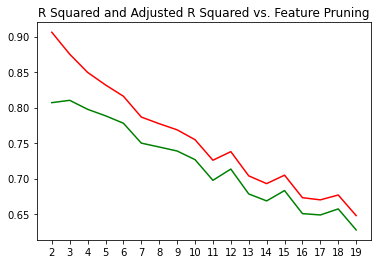

In [42]:
plt.plot(range(2,20), r_vals[1:], c = 'r')
plt.plot(range(2,20), r_adj_vals[1:], c = 'g')
plt.xticks(np.arange(2, 20, 1))
plt.title("R Squared and Adjusted R Squared vs. Feature Pruning")
plt.show()

In [43]:
pred_diff = 180
window = 180
feature_pruning = 3
X_dat = createFeatureVectors(dat, window, feature_pruning)
model = sm.OLS(np.array(Y_dat), np.array(X_dat))
results = model.fit()

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     13.22
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        19:26:54   Log-Likelihood:                 2873.8
No. Observations:                7530   AIC:                            -587.5
Df Residuals:                    4950   BIC:                         1.728e+04
Df Model:                        2580                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0218      0.008      2.759      0.006       0.006       0.037
x2            -0.0456      0.065     -0.699      0.485      -0.174       0.082
x3             0.0185      0.078      0.238      0.812      -0.134       0.170
x4             0.2306      0.082      2.808      0.005       0.070       0.392
x5             0.2798      0.085      3.281      0.001       0.113       0.447
x6             0.1469      0.087      1.698      0.090      -0.023       0.316
x7            -0.0382      0.088     -0.435      0.663      -0.210       0.134
x8            -0.2647      0.090     -2.936      0.003      -0.441      -0.088
x9            -0.3732      0.092     -4.042      0.000      -0.554      -0.192
x10           -0.5568      0.095     -5.885      0.000      -0.742      -0.371
x11           -0.6042      0.096     -6.265      0.000      -0.793      -0.415
x12           -0.7155      0.101     -7.114      0.000      -0.913      -0.518
x13           -0.7348      0.101     -7.268      0.000      -0.933      -0.537
x14           -0.6808      0.103     -6.592      0.000      -0.883      -0.478
x15           -0.7383      0.107     -6.894      0.000      -0.948      -0.528
x16           -0.7819      0.111     -7.075      0.000      -0.999      -0.565
x17           -0.8042      0.109     -7.372      0.000      -1.018      -0.590
x18           -0.9160      0.109     -8.370      0.000      -1.131      -0.701
x19           -1.0281      0.111     -9.269      0.000      -1.246      -0.811
x20           -0.8791      0.112     -7.819      0.000      -1.100      -0.659
x21           -0.7331      0.113     -6.486      0.000      -0.955      -0.512
x22           -0.7461      0.114     -6.572      0.000      -0.969      -0.524
x23           -0.7162      0.114     -6.260      0.000      -0.941      -0.492
x24           -0.6044      0.116     -5.226      0.000      -0.831      -0.378
x25           -0.3481      0.118     -2.959      0.003      -0.579      -0.117
x26            0.1330      0.120      1.112      0.266      -0.102       0.368
x27            0.4248      0.121      3.517      0.000       0.188       0.662
x28            0.3549      0.121      2.929      0.003       0.117       0.592
x29            0.4256      0.124      3.425      0.001       0.182       0.669
x30            0.5165      0.131      3.957      0.000       0.261       0.772
x31            0.6555      0.135      4.864      0.000       0.391       0.920
x32            0.6339      0.137      4.641      0.000       0.366       0.902
x33            0.7906      0.134      5.882      0.000       0.527       1.054
x34            0.8683      0.134      6.477      0.000       0.605       1.131
x35            1.0186      0.133      7.642      0.000       0.757       1.280
x36            1.2350      0.135      9.151      0.000       0.970       1.500
x3

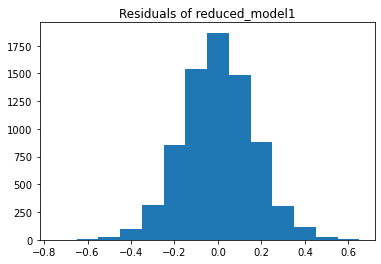

In [177]:
plt.hist(reduced_results1.resid, bins = np.arange(-.75, .75, .1))
plt.title("Residuals of reduced_model1")
plt.show()

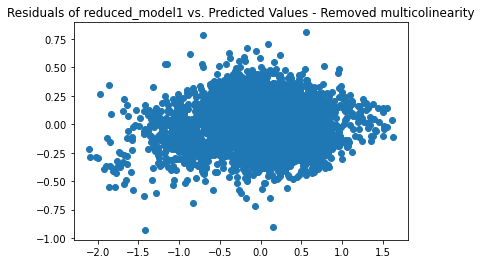

In [75]:
plt.scatter(reduced_results1.fittedvalues, reduced_results1.resid)
plt.title("Residuals of reduced_model1 vs. Predicted Values - Removed multicolinearity")
plt.show()

In [176]:
corrmat = np.corrcoef(reduced.T)
np.set_printoptions(precision=3)
print("Correlation matrix for first 10 variables\n", corrmat[:10,:10])
multilin_list = []
for i in range(len(corrmat)):
    for j in range(i):
        if corrmat[i][j] > .8:
            multilin_list.append((i,j))
to_drop = []
while len(multilin_list) > 0:
    to_drop.append(multilin_list[0][0])
    val = multilin_list[0][0]s
    tmp = []
    for pair in multilin_list:
        if val not in pair:
            tmp.append(pair)
    multilin_list = tmp
print("\nColumns to drop:", to_drop)
reduced_X1 = np.delete(X_dat, to_drop, axis = 1)
reduced_model1 = sm.OLS(np.array(Y_dat), np.array(reduced_X1))
reduced_results1 = reduced_model1.fit()

Correlation matrix for first 10 variables
 [[ 1.    -0.009 -0.019 -0.02   0.006  0.006  0.002 -0.002  0.007  0.003]
 [-0.009  1.    -0.007  0.005 -0.013 -0.018 -0.011 -0.023 -0.005  0.04 ]
 [-0.019 -0.007  1.    -0.016 -0.007 -0.016 -0.019 -0.006 -0.038 -0.005]
 [-0.02   0.005 -0.016  1.     0.018 -0.002 -0.019 -0.022 -0.005 -0.048]
 [ 0.006 -0.013 -0.007  0.018  1.    -0.025  0.005 -0.003 -0.009 -0.008]
 [ 0.006 -0.018 -0.016 -0.002 -0.025  1.    -0.031 -0.001 -0.011 -0.019]
 [ 0.002 -0.011 -0.019 -0.019  0.005 -0.031  1.    -0.032 -0.007 -0.011]
 [-0.002 -0.023 -0.006 -0.022 -0.003 -0.001 -0.032  1.    -0.052 -0.017]
 [ 0.007 -0.005 -0.038 -0.005 -0.009 -0.011 -0.007 -0.052  1.    -0.056]
 [ 0.003  0.04  -0.005 -0.048 -0.008 -0.019 -0.011 -0.017 -0.056  1.   ]]

Columns to drop: [40, 74, 141, 270, 367, 443, 600, 1527, 1530]


In [63]:
reduced_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     13.10
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        19:53:57   Log-Likelihood:                 2826.6
No. Observations:                7530   AIC:                            -511.2
Df Residuals:                    4959   BIC:                         1.730e+04
Df Model:                        2571                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0209      0.008      2.687      0.007       0.006       0.036
x2            -0.0511      0.065     -0.781      0.435      -0.179       0.077
x3             0.0023      0.078      0.030      0.976      -0.150       0.154
x4             0.2252      0.082      2.731      0.006       0.064       0.387
x5             0.2776      0.085      3.262      0.001       0.111       0.444
x6             0.1540      0.086      1.798      0.072      -0.014       0.322
x7            -0.0126      0.087     -0.145      0.884      -0.182       0.157
x8            -0.1931      0.088     -2.199      0.028      -0.365      -0.021
x9            -0.3436      0.091     -3.788      0.000      -0.521      -0.166
x10           -0.5466      0.093     -5.853      0.000      -0.730      -0.364
x11           -0.5813      0.095     -6.131      0.000      -0.767      -0.395
x12           -0.6959      0.098     -7.073      0.000      -0.889      -0.503
x13           -0.7007      0.099     -7.087      0.000      -0.894      -0.507
x14           -0.6420      0.100     -6.398      0.000      -0.839      -0.445
x15           -0.6948      0.102     -6.813      0.000      -0.895      -0.495
x16           -0.7485      0.108     -6.941      0.000      -0.960      -0.537
x17           -0.7657      0.107     -7.126      0.000      -0.976      -0.555
x18           -0.8938      0.109     -8.233      0.000      -1.107      -0.681
x19           -1.0075      0.110     -9.155      0.000      -1.223      -0.792
x20           -0.8605      0.112     -7.716      0.000      -1.079      -0.642
x21           -0.7147      0.112     -6.395      0.000      -0.934      -0.496
x22           -0.7187      0.109     -6.578      0.000      -0.933      -0.504
x23           -0.7299      0.113     -6.473      0.000      -0.951      -0.509
x24           -0.6471      0.114     -5.651      0.000      -0.872      -0.423
x25           -0.3823      0.117     -3.262      0.001      -0.612      -0.153
x26            0.1098      0.120      0.919      0.358      -0.125       0.344
x27            0.4299      0.121      3.547      0.000       0.192       0.667
x28            0.4070      0.121      3.354      0.001       0.169       0.645
x29            0.5061      0.124      4.073      0.000       0.263       0.750
x30            0.6184      0.130      4.765      0.000       0.364       0.873
x31            0.7728      0.133      5.822      0.000       0.513       1.033
x32            0.7333      0.135      5.435      0.000       0.469       0.998
x33            0.8515      0.133      6.379      0.000       0.590       1.113
x34            0.8956      0.133      6.713      0.000       0.634       1.157
x35            1.0366      0.133      7.817      0.000       0.777       1.297
x36            1.2466      0.134      9.318      0.000       0.984       1.509
x3

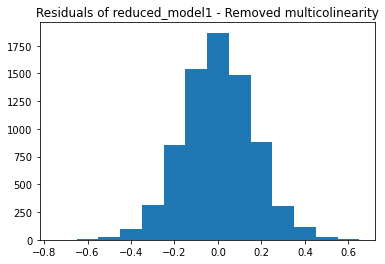

In [71]:
plt.hist(reduced_results1.resid, bins = np.arange(-.75, .75, .1))
plt.title("Residuals of reduced_model1 - Removed multicolinearity")
plt.show()

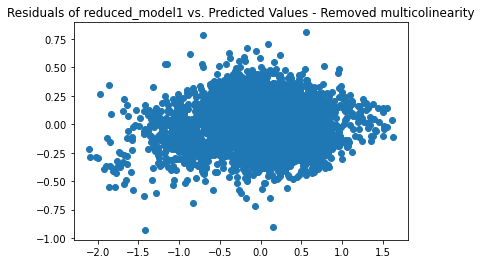

In [73]:
plt.scatter(reduced_results1.fittedvalues, reduced_results1.resid)
plt.title("Residuals of reduced_model1 vs. Predicted Values - Removed multicolinearity")
plt.show()

In [98]:
kept = np.abs(reduced_results1.tvalues) > 1.645
reduced_X2 = reduced_X1[:, kept]

In [99]:
reduced_model2 = sm.OLS(np.array(Y_dat), np.array(reduced_X2))
reduced_results2 = reduced_model2.fit()

In [100]:
reduced_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     18.86
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        20:21:56   Log-Likelihood:                 1751.8
No. Observations:                7530   AIC:                            -419.6
Df Residuals:                    5988   BIC:                         1.026e+04
Df Model:                        1542                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0153      0.002      6.241      0.000       0.011       0.020
x2             0.2704      0.055      4.949      0.000       0.163       0.378
x3             0.2708      0.056      4.816      0.000       0.161       0.381
x4             0.1416      0.057      2.480      0.013       0.030       0.253
x5            -0.2139      0.058     -3.703      0.000      -0.327      -0.101
x6            -0.4396      0.063     -6.940      0.000      -0.564      -0.315
x7            -0.5290      0.065     -8.184      0.000      -0.656      -0.402
x8            -0.5835      0.067     -8.725      0.000      -0.715      -0.452
x9            -0.6833      0.068    -10.041      0.000      -0.817      -0.550
x10           -0.6066      0.068     -8.859      0.000      -0.741      -0.472
x11           -0.6677      0.068     -9.876      0.000      -0.800      -0.535
x12           -0.6484      0.068     -9.529      0.000      -0.782      -0.515
x13           -0.7277      0.068    -10.749      0.000      -0.860      -0.595
x14           -0.6813      0.057    -12.030      0.000      -0.792      -0.570
x15           -0.7849      0.060    -13.119      0.000      -0.902      -0.668
x16           -0.9701      0.069    -14.066      0.000      -1.105      -0.835
x17           -0.7242      0.073     -9.909      0.000      -0.867      -0.581
x18           -0.5860      0.073     -8.032      0.000      -0.729      -0.443
x19           -0.7000      0.075     -9.330      0.000      -0.847      -0.553
x20           -0.6063      0.075     -8.135      0.000      -0.752      -0.460
x21           -0.5841      0.075     -7.793      0.000      -0.731      -0.437
x22           -0.4020      0.071     -5.631      0.000      -0.542      -0.262
x23            0.1698      0.073      2.313      0.021       0.026       0.314
x24            0.3029      0.078      3.895      0.000       0.150       0.455
x25            0.3683      0.083      4.443      0.000       0.206       0.531
x26            0.4753      0.087      5.480      0.000       0.305       0.645
x27            0.6609      0.085      7.735      0.000       0.493       0.828
x28            0.7137      0.084      8.513      0.000       0.549       0.878
x29            0.7855      0.086      9.121      0.000       0.617       0.954
x30            0.8075      0.084      9.571      0.000       0.642       0.973
x31            0.9903      0.082     12.124      0.000       0.830       1.150
x32            1.0217      0.086     11.839      0.000       0.853       1.191
x33            0.9837      0.090     10.894      0.000       0.807       1.161
x34            1.0405      0.088     11.884      0.000       0.869       1.212
x35            0.6784      0.088      7.668      0.000       0.505       0.852
x36            0.3044      0.080      3.784      0.000       0.147       0.462
x3

In [115]:
f_score = (reduced_results1.ssr/(1-reduced_results1.rsquared)*reduced_results1.rsquared - reduced_results2.ssr/(1-reduced_results2.rsquared)*reduced_results2.rsquared)/(sum(kept == 0))/reduced_results1.mse_resid
print("Partial F-test statistic, dropping vars a = .1: \n", f_score)
print("\nP-value: \n", 5.26e-25)

Partial F-test statistic, dropping vars a = .1: 
 1.5921701871932574

P-value: 
 5.26e-25


In [97]:
kept2 = np.abs(reduced_results1.tvalues) > 1.282
reduced_X2_2 = reduced_X1[:, kept2]
reduced_model2_2 = sm.OLS(np.array(Y_dat), np.array(reduced_X2_2))
reduced_results2_2 = reduced_model2_2.fit()
reduced_results2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     19.18
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        20:21:48   Log-Likelihood:                 2318.2
No. Observations:                7530   AIC:                            -1136.
Df Residuals:                    5780   BIC:                         1.099e+04
Df Model:                        1750                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0191      0.003      7.067      0.000       0.014       0.024
x2             0.2911      0.054      5.358      0.000       0.185       0.398
x3             0.2735      0.056      4.880      0.000       0.164       0.383
x4             0.1433      0.057      2.527      0.012       0.032       0.254
x5            -0.2024      0.057     -3.577      0.000      -0.313      -0.091
x6            -0.3646      0.063     -5.829      0.000      -0.487      -0.242
x7            -0.5379      0.064     -8.350      0.000      -0.664      -0.412
x8            -0.5926      0.066     -8.933      0.000      -0.723      -0.463
x9            -0.7184      0.067    -10.643      0.000      -0.851      -0.586
x10           -0.6391      0.069     -9.269      0.000      -0.774      -0.504
x11           -0.6118      0.068     -8.962      0.000      -0.746      -0.478
x12           -0.6333      0.068     -9.356      0.000      -0.766      -0.501
x13           -0.7334      0.067    -10.881      0.000      -0.866      -0.601
x14           -0.7196      0.057    -12.545      0.000      -0.832      -0.607
x15           -0.8961      0.066    -13.528      0.000      -1.026      -0.766
x16           -1.0518      0.073    -14.473      0.000      -1.194      -0.909
x17           -0.8962      0.075    -12.017      0.000      -1.042      -0.750
x18           -0.7245      0.074     -9.760      0.000      -0.870      -0.579
x19           -0.7983      0.076    -10.507      0.000      -0.947      -0.649
x20           -0.7216      0.075     -9.625      0.000      -0.869      -0.575
x21           -0.6484      0.076     -8.574      0.000      -0.797      -0.500
x22           -0.3800      0.073     -5.177      0.000      -0.524      -0.236
x23            0.3530      0.077      4.572      0.000       0.202       0.504
x24            0.4304      0.082      5.258      0.000       0.270       0.591
x25            0.5456      0.085      6.452      0.000       0.380       0.711
x26            0.6713      0.090      7.479      0.000       0.495       0.847
x27            0.8151      0.090      9.009      0.000       0.638       0.992
x28            0.7891      0.087      9.023      0.000       0.618       0.961
x29            0.8523      0.090      9.504      0.000       0.676       1.028
x30            0.8629      0.089      9.691      0.000       0.688       1.037
x31            1.0084      0.088     11.424      0.000       0.835       1.181
x32            1.2340      0.090     13.677      0.000       1.057       1.411
x33            1.1749      0.091     12.944      0.000       0.997       1.353
x34            1.1702      0.090     12.947      0.000       0.993       1.347
x35            0.6735      0.091      7.400      0.000       0.495       0.852
x36            0.3059      0.080      3.837      0.000       0.150       0.462
x3

In [117]:
f_score_2 = (reduced_results1.ssr/(1-reduced_results1.rsquared)*reduced_results1.rsquared - reduced_results2_2.ssr/(1-reduced_results2_2.rsquared)*reduced_results2_2.rsquared)/(sum(kept2 == 0))/reduced_results1.mse_resid
print("Partial F-test statistic, dropping vars a = .2: \n", f_score_2)
print("\nP-value: \n", .9942)

Partial F-test statistic, dropping vars a = .2: 
 0.8732152737007233

P-value: 
 0.9942


In [154]:
lag_col = np.zeros((reduced_X2.shape[0],1))
lag_col[1:,0] = Y_dat[:reduced_X2.shape[0]-1]
reduced_X3 = np.append(reduced_X2_2, lag_col, axis = 1)

In [155]:
reduced_X3.shape

(7530, 1751)

In [156]:
reduced_model3 = sm.OLS(np.array(Y_dat), np.array(reduced_X3))
reduced_results3 = reduced_model3.fit()
reduced_results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     70.49
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        21:04:45   Log-Likelihood:                 6795.2
No. Observations:                7530   AIC:                        -1.009e+04
Df Residuals:                    5779   BIC:                             2040.
Df Model:                        1751                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0041      0.001      2.716      0.007       0.001       0.007
x2             0.0322      0.030      1.071      0.284      -0.027       0.091
x3             0.0615      0.031      1.985      0.047       0.001       0.122
x4             0.0551      0.031      1.760      0.078      -0.006       0.116
x5            -0.1146      0.031     -3.670      0.000      -0.176      -0.053
x6            -0.1268      0.035     -3.668      0.000      -0.195      -0.059
x7            -0.1462      0.036     -4.094      0.000      -0.216      -0.076
x8            -0.1441      0.037     -3.914      0.000      -0.216      -0.072
x9            -0.1851      0.038     -4.931      0.000      -0.259      -0.112
x10           -0.1252      0.038     -3.268      0.001      -0.200      -0.050
x11           -0.1039      0.038     -2.740      0.006      -0.178      -0.030
x12           -0.1826      0.038     -4.861      0.000      -0.256      -0.109
x13           -0.2290      0.037     -6.113      0.000      -0.302      -0.156
x14           -0.2197      0.032     -6.876      0.000      -0.282      -0.157
x15           -0.2534      0.037     -6.854      0.000      -0.326      -0.181
x16           -0.2527      0.041     -6.209      0.000      -0.333      -0.173
x17           -0.1518      0.042     -3.645      0.000      -0.234      -0.070
x18           -0.1714      0.041     -4.155      0.000      -0.252      -0.091
x19           -0.2544      0.042     -6.028      0.000      -0.337      -0.172
x20           -0.2250      0.042     -5.409      0.000      -0.307      -0.143
x21           -0.1845      0.042     -4.399      0.000      -0.267      -0.102
x22           -0.0898      0.041     -2.213      0.027      -0.169      -0.010
x23            0.1296      0.043      3.038      0.002       0.046       0.213
x24            0.0779      0.045      1.721      0.085      -0.011       0.167
x25            0.1896      0.047      4.055      0.000       0.098       0.281
x26            0.2024      0.050      4.071      0.000       0.105       0.300
x27            0.2061      0.050      4.104      0.000       0.108       0.304
x28            0.2555      0.048      5.270      0.000       0.160       0.351
x29            0.2679      0.050      5.385      0.000       0.170       0.365
x30            0.2242      0.049      4.534      0.000       0.127       0.321
x31            0.2436      0.049      4.955      0.000       0.147       0.340
x32            0.3293      0.050      6.533      0.000       0.230       0.428
x33            0.3635      0.051      7.186      0.000       0.264       0.463
x34            0.3889      0.050      7.726      0.000       0.290       0.488
x35            0.1998      0.050      3.964      0.000       0.101       0.299
x36            0.1297      0.044      2.946      0.003       0.043       0.216
x3

In [55]:
corrmat = np.corrcoef(reduced.T)
multilin_list = []
for i in range(len(corrmat)):
    for j in range(i):
        if corrmat[i][j] > .8:
            multilin_list.append((i,j))
to_drop = []
while len(multilin_list) > 0:
    to_drop.append(multilin_list[0][0])
    val = multilin_list[0][0]
    tmp = []
    for pair in multilin_list:
        if val not in pair:
            tmp.append(pair)
    multilin_list = tmp
print(to_drop)
reduced2 = np.delete(reduced, to_drop, axis = 1)
model3 = sm.OLS(np.array(Y_dat), np.array(reduced2))
results3 = model3.fit()

In [164]:
X_dat.shape

(7530, 2580)

In [166]:
print("Variable: %s\nObservations: %s\nMean: %s\nStandard Deviation: %s\nMin: %s\nMax: %s\n" %("V1", X_dat.shape[0], np.mean(X_dat[:,1]), np.std(X_dat[:,1]), np.min(X_dat[:,1]), np.max(X_dat[:,1])))

Variable: V1
Observations: 7530
Mean: 7.96812748997975e-06
Standard Deviation: 0.10210604304748291
Min: -0.5300000000000011
Max: 0.5999999999999943



(array([   3.,    7.,   19.,   22.,   73.,  117.,  277.,  486., 1080.,
        1450., 1769., 1218.,  559.,  271.,   96.,   44.,   22.,    6.,
           3.]),
 array([-5.00000000e-01, -4.50000000e-01, -4.00000000e-01, -3.50000000e-01,
        -3.00000000e-01, -2.50000000e-01, -2.00000000e-01, -1.50000000e-01,
        -1.00000000e-01, -5.00000000e-02, -1.11022302e-16,  5.00000000e-02,
         1.00000000e-01,  1.50000000e-01,  2.00000000e-01,  2.50000000e-01,
         3.00000000e-01,  3.50000000e-01,  4.00000000e-01,  4.50000000e-01]),
 <a list of 19 Patch objects>)

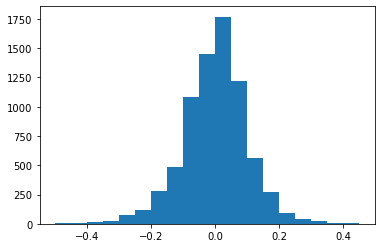

In [168]:
plt.hist(X_dat[:,1], bins = np.arange(-.5, .5, .05))


In [61]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     16.21
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        19:45:03   Log-Likelihood:                 1250.9
No. Observations:                7530   AIC:                             554.3
Df Residuals:                    6002   BIC:                         1.114e+04
Df Model:                        1528                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0067      0.000    -14.500      0.000      -0.008      -0.006
x2             0.2521      0.058      4.357      0.000       0.139       0.366
x3             0.2828      0.059      4.764      0.000       0.166       0.399
x4             0.1787      0.061      2.949      0.003       0.060       0.298
x5            -0.2383      0.063     -3.799      0.000      -0.361      -0.115
x6            -0.3753      0.068     -5.556      0.000      -0.508      -0.243
x7            -0.4481      0.069     -6.533      0.000      -0.583      -0.314
x8            -0.5423      0.071     -7.638      0.000      -0.681      -0.403
x9            -0.6100      0.072     -8.444      0.000      -0.752      -0.468
x10           -0.5266      0.070     -7.558      0.000      -0.663      -0.390
x11           -0.5915      0.073     -8.130      0.000      -0.734      -0.449
x12           -0.6318      0.075     -8.455      0.000      -0.778      -0.485
x13           -0.6305      0.068     -9.288      0.000      -0.764      -0.497
x14           -0.6717      0.060    -11.143      0.000      -0.790      -0.554
x15           -0.9153      0.070    -13.095      0.000      -1.052      -0.778
x16           -1.0655      0.073    -14.661      0.000      -1.208      -0.923
x17           -0.7459      0.075    -10.011      0.000      -0.892      -0.600
x18           -0.6617      0.078     -8.522      0.000      -0.814      -0.510
x19           -0.7639      0.080     -9.581      0.000      -0.920      -0.608
x20           -0.6445      0.079     -8.161      0.000      -0.799      -0.490
x21           -0.5617      0.081     -6.953      0.000      -0.720      -0.403
x22           -0.3420      0.076     -4.473      0.000      -0.492      -0.192
x23            0.2402      0.080      2.998      0.003       0.083       0.397
x24            0.3011      0.082      3.664      0.000       0.140       0.462
x25            0.3076      0.087      3.535      0.000       0.137       0.478
x26            0.3404      0.089      3.814      0.000       0.165       0.515
x27            0.6008      0.093      6.457      0.000       0.418       0.783
x28            0.6895      0.091      7.599      0.000       0.512       0.867
x29            0.7921      0.094      8.444      0.000       0.608       0.976
x30            0.7475      0.091      8.212      0.000       0.569       0.926
x31            0.8545      0.089      9.630      0.000       0.681       1.028
x32            0.9749      0.091     10.681      0.000       0.796       1.154
x33            0.9360      0.092     10.205      0.000       0.756       1.116
x34            0.9223      0.087     10.569      0.000       0.751       1.093
x35            0.7120      0.095      7.494      0.000       0.526       0.898
x36            0.4228      0.092      4.581      0.000       0.242       0.604
x3

In [82]:
X_dat.shape

torch.Size([7530, 7920])

In [83]:
Y_dat.shape

torch.Size([7530])

In [69]:
X_dat = createCNNFeatureVectors(dat, window)
X_dat.shape

torch.Size([67770, 2640])

In [70]:

Y_dat = createClassLabels(dat, window, pred_col)
Y_dat.shape

torch.Size([67770])

In [72]:
Y_dat[0:10]

tensor([-1.1000, -0.9050, -0.8600, -0.8900, -0.8500, -0.8700, -0.8650, -1.0050,
        -0.9400, -1.1200], dtype=torch.float64)

In [73]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_dat, Y_dat)
r = reg.score(X_dat, Y_dat)
adj_r = 1 - (1-r)*(X_dat.shape[0]-1)/(X_dat.shape[0]-X_dat.shape[1]-1)

In [74]:
print(r)
print(adj_r)

0.07894465275833729
0.04160973103808985


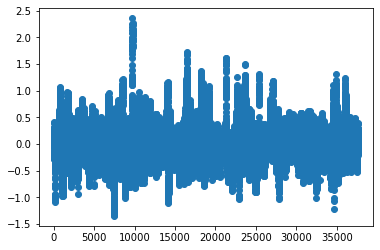

In [79]:
residual = reg.predict(X_dat) - np.array(Y_dat)
plt.scatter(range(len(residual)), residual)

In [16]:
print(Y_dat.shape)
print(X_dat.shape)
batch_size = 10

train_X = X_dat[0:int(.8*len(X_dat))]
train_Y = Y_dat[0:int(.8*len(X_dat))]

train = torch.utils.data.TensorDataset(X_dat, Y_dat)

val_X = X_dat[int(.8*len(X_dat)):]
val_Y = Y_dat[int(.8*len(X_dat)):]

train = torch.utils.data.TensorDataset(train_X, train_Y)
val = torch.utils.data.TensorDataset(val_X, val_Y)


torch.Size([92619])
torch.Size([92619, 2, 22, 20])


In [16]:

class priceNet(nn.Module):

    def __init__(self):

        super(priceNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 2, [3,3], stride = 1, padding = 1, bias = False)
        #self.batch1 = nn.BatchNorm2d(4)
        self.relu = nn.Tanh()
        self.conv2 = nn.Conv2d(2, 2, [3,3], stride = 1, padding = 0, bias = True)
        self.conv3 = nn.Conv2d(2, 2, [3,3], stride = 1, padding = 1, bias = True)
        self.conv4 = nn.Conv2d(2, 1, [3,3], stride = 1, padding = 1, bias = True)
        self.pool1 = nn.MaxPool2d([2,2])
        self.pool2 = nn.MaxPool2d([2,2])
        self.lin = nn.Linear(16, 1)
        self.drop = nn.Dropout2d(p=0.2)
        '''
        self.conv1.weight = nn.Parameter(torch.rand((4,1,3,3))-.5)
        self.batch1.weight = nn.Parameter(torch.rand((4,))-.5)
        self.batch1.bias = nn.Parameter(torch.rand((4,))-.5)

        self.conv2.weight = nn.Parameter(torch.rand((4,4,3,3))-.5)
        self.conv2.bias = nn.Parameter(torch.rand(4,)-.5)

        self.conv3.weight = nn.Parameter(torch.rand((4,4,3,3))-.5)
        self.conv3.bias = nn.Parameter(torch.rand(4,)-.5)

        self.lin.weight = nn.Parameter(torch.rand((36,64*64))-.5)
        '''
        '''
        for param in self.parameters():
            param.data = param.data.half()
        '''
    def forward(self, x):
        #print(x.element_size() * x.nelement())
        #print(x.shape)
        f1 = self.conv2(x.view((x.shape[0], 2, 21, -1)))
        #print(f1.shape)
        #f2 = self.conv2(self.relu(f1))
        #print(f2.shape)
        f3 = self.pool1(self.drop(f1))
        #print(f3.shape)
        f4 = self.pool2(self.conv3(self.drop(self.relu(f3))))
        #print(f4.shape)
        f5 = self.conv4(self.drop(self.relu(f4)))
        #print(f5.shape)
        f6 = self.lin(f5.view((x.shape[0], 16)))
        #print(f6.shape)
        #f7 = self.soft(f6)
        return f6.view(-1)


In [9]:

def fit_and_validate(net, loss_func, optimizer, train, val, n_epochs, batch_size =100):
    """
    @param net: the neural network
    @param optimizer: a optim.Optimizer used for some variant of stochastic gradient descent
    @param train: a torch.utils.data.Dataset
    @param val: a torch.utils.data.Dataset
    @param n_epochs: the number of epochs over which to do gradient descent
    @param batch_size: the number of samples to use in each batch of gradient descent
    @return train_epoch_loss, validation_epoch_loss: two arrays of length n_epochs+1, containing the mean loss at the beginning of training and after each epoch
    """
    net.eval() #put the net in evaluation mode
    train_dl = torch.utils.data.DataLoader(train, batch_size)
    val_dl = torch.utils.data.DataLoader(val, batch_size)
    with torch.no_grad():
        # compute the mean loss on the training set at the beginning of iteration
        total=0
        b = 0
        t_l = 0
        for X,Y in train_dl:
            b+=1
            X_temp = X.float().cuda()
            Y_temp = Y.float().cuda()
            pred = net(X_temp)
            t_l += loss_func(pred, Y_temp)
            total += Y.shape[0]

            del X_temp
            del Y_temp
            
        print("avg initial loss:", t_l/total)

    for i in range(n_epochs):
        print(torch.cuda.memory_allocated(0))
        print("base epoch #", i)
        net.train() #put the net in train mode
        first = True
        train_epoch_loss = []
        val_epoch_loss = []
        first = True
        batch = 0
        for X,Y in train_dl:
            X_temp = X.float().cuda()
            pred = net(X_temp)
            #print(pred)
            Y_temp = Y.float().cuda()
            
            loss = loss_func(pred, Y_temp)
            if batch%1000 == 0:
                print("batchnum: ", batch)
                print(pred)
                print(Y_temp)
                print(loss)
                
            batch+=1
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            del Y_temp
            del X_temp
        with torch.no_grad():
            net.eval() #put the net in evaluation mode
            t_l = 0
            v_l = 0
            total=0
            b = 0
            for X,Y in train_dl:
                b+=1
                X_temp = X.float().cuda()
                Y_temp = Y.float().cuda()
                pred = net(X_temp)
                t_l += loss_func(pred, Y_temp)

                total += Y.shape[0]

                del X_temp
                del Y_temp

                break
            t_l/=total
            #print("bias:", sum(pred))
            total=0
            b=0
            for X,Y in val_dl:
                b+=1
                X_temp = X.float().cuda()
                Y_temp = Y.float().cuda()
                pred = net(X_temp)
                #print(pred)
                v_l += loss_func(pred, Y_temp)
                total += Y.shape[0]
                del X_temp
                del Y_temp
            v_l/=total

            train_epoch_loss.append(t_l)
            val_epoch_loss.append(v_l)
            #print("bias:", sum(pred))

            print("train loss:", train_epoch_loss[len(train_epoch_loss)-1])
            print("val loss:", val_epoch_loss[len(train_epoch_loss)-1])

    return train_epoch_loss, val_epoch_loss

In [18]:

predNet = priceNet().cuda()
optimizer = optim.Adam(predNet.parameters(), lr = .0001)
print(torch.cuda.memory_allocated(0))
tl, vl = fit_and_validate(predNet, nn.L1Loss(), optimizer, train, val, 1000, 10)

4608
avg initial loss: tensor(0.0527, device='cuda:0')
5632
base epoch # 0
batchnum:  0
tensor([ 0.1073,  0.0860, -0.1380,  0.1123, -0.1879, -0.1308, -0.1809,  0.0828,
         0.1396, -0.1592], device='cuda:0', grad_fn=<ViewBackward>)
tensor([1., 1., 1., 1., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor(0.6434, device='cuda:0', grad_fn=<L1LossBackward>)
batchnum:  1000
tensor([ 0.0266, -0.0011, -0.0376,  0.0307,  0.0415,  0.0212,  0.0521,  0.0531,
         0.0797,  0.0480], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor(0.5162, device='cuda:0', grad_fn=<L1LossBackward>)
batchnum:  2000
tensor([0.0575, 0.0260, 0.0290, 0.0223, 0.0247, 0.0041, 0.0608, 0.0319, 0.0561,
        0.0319], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor(0.4999, device='cuda:0', grad_fn=<L1LossBackward>)
batchnum:  3000
tensor([0.0703, 0.0230, 0.0107, 0.0115, 0.0325, 0.0178, 0.

KeyboardInterrupt: 

In [20]:
reg_train_X = train_X.view(train_X[:,0,:,:].shape[0], -1)
reg_val_X = val_X.view(val_X[:,0,:,:].shape[0], -1)

In [21]:
iters = [1, 2, 5, 10, 20]
for i in iters:
    reg = LogisticRegression(max_iter=i)
    reg.fit(reg_train_X, train_Y)
    print()
    print("train acc it = " + str(i),":", reg.score(reg_train_X, train_Y))
    print("val acc it = " + str(i), ":", reg.score(reg_val_X, val_Y))


train acc it = 1 : 0.5601457588231324
val acc it = 1 : 0.5525264521701576

train acc it = 2 : 0.5623861259194277
val acc it = 2 : 0.5492334269056359

train acc it = 5 : 0.5650988595721709
val acc it = 5 : 0.5501511552580436

train acc it = 10 : 0.5652608138200959
val acc it = 10 : 0.5486396026776075

train acc it = 20 : 0.5658276536878332
val acc it = 20 : 0.5489635068019866


In [25]:
print(float(sum(val_Y))/val_Y.shape[0])

0.4465018354567048


In [158]:
original_data = pd.read_csv("datasets/2017_M1_IEX.csv")

In [162]:
original_data.SPY.unique()

array(['SPY', 'AAPL', 'MSFT', 'AMZN', 'BRK.B', 'FB', 'JNJ', 'JPM', 'XOM',
       'GOOG', 'GOOGL', 'BAC', 'PFE', 'UNH', 'V', 'T', 'WFC', 'CVX', 'VZ',
       'HD', 'INTC'], dtype=object)